# Описание проекта

Компания "Жёлтый путь" собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

---

Цель:

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

# Подготовка рабочей среды

In [1]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import ipywidgets
import catboost
from catboost import CatBoostRegressor


from lightgbm import LGBMRegressor


from IPython.display import clear_output

# убрать предупреждения
import warnings
warnings.filterwarnings('ignore')

# настроим точность вывода до 2-х десятичных знаков и разделители тысяч (групп разрядов) для больших чисел
pd.set_option('display.float_format', '{:,.2f}'.format)

# необходимо для показа всех столбцов.
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
seed = 404

# Загрузка и обзор данных

In [3]:
if os.path.exists(r'/datasets/taxi.csv'):
    data = pd.read_csv(r'/datasets/taxi.csv', index_col=[0], parse_dates=[0])
elif os.path.exists(r'taxi.csv'):
    data = pd.read_csv(r'taxi.csv', index_col=[0], parse_dates=[0])
else:
    raise FileNotFoundError('Check path file')

In [4]:
data = data.resample('1H').sum()

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
# data.shape
print(f'Количество записей: {data.shape[0]}')

Количество записей: 4416


In [8]:
# количество пропусков
data.isna().sum()

num_orders    0
dtype: int64

**Промежуточный вывод:**

Данные успешно загружены.Был произведён ресемплинг по 1-му часу с суммированием значений в качестве агрегации. Название столбцов корректное, также как и тип столбцов. Пропусков нет.

# Анализ данных

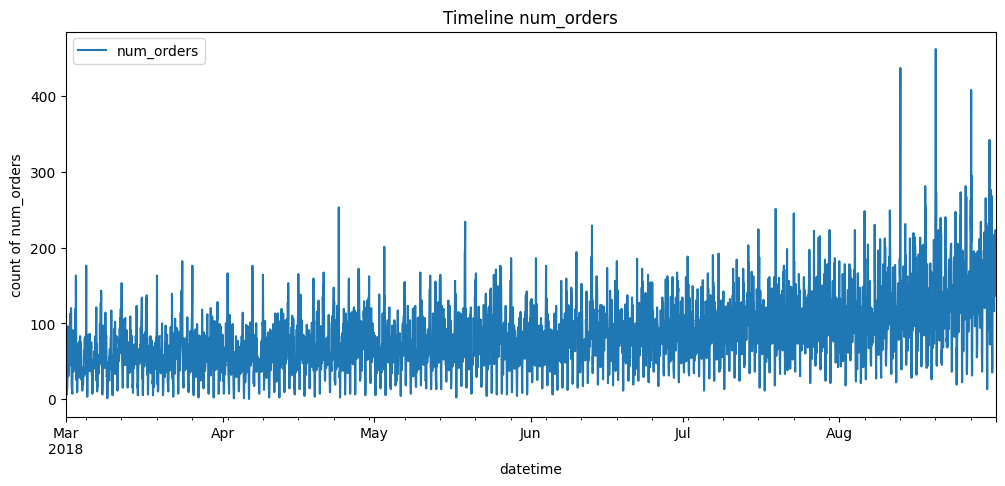

In [9]:
gr = data.plot(ylabel='count of num_orders', title='Timeline num_orders', figsize=(12, 5))

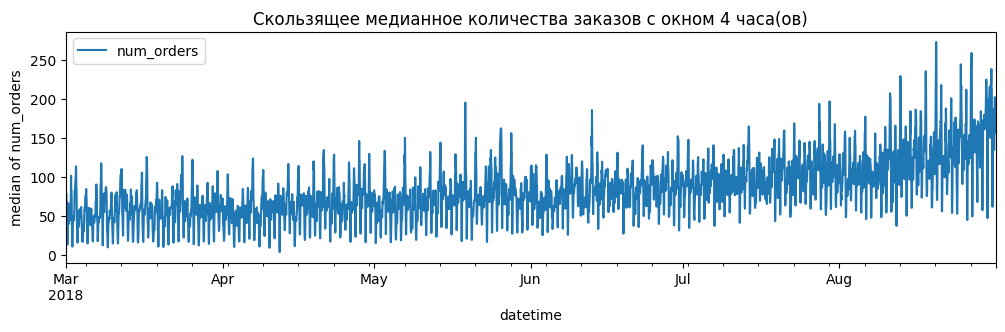

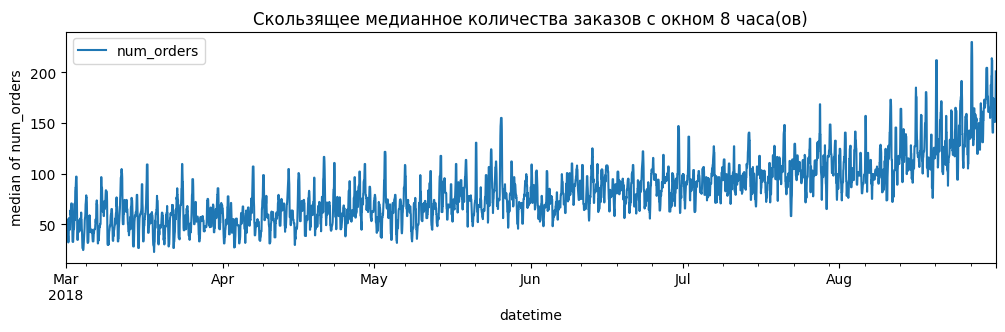

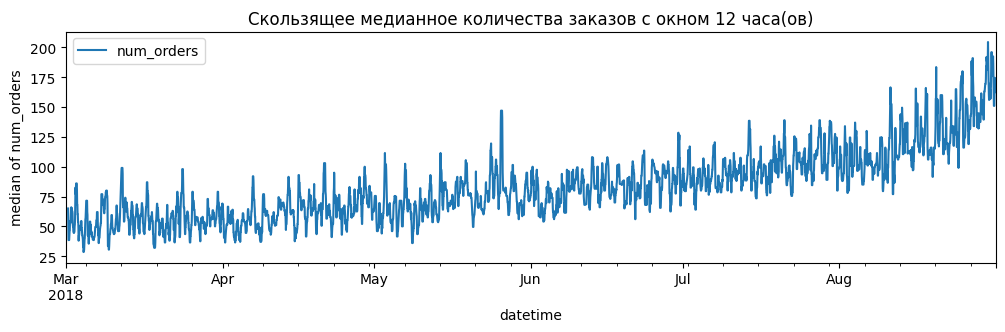

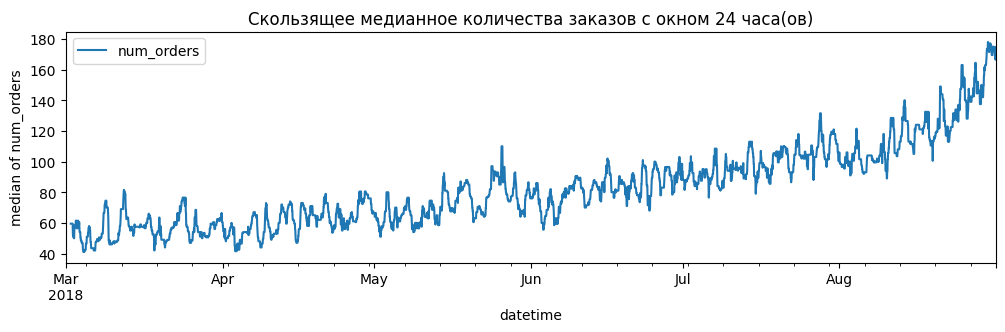

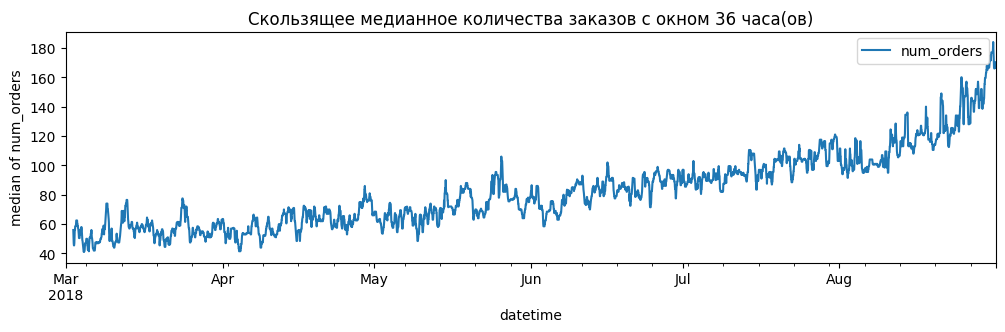

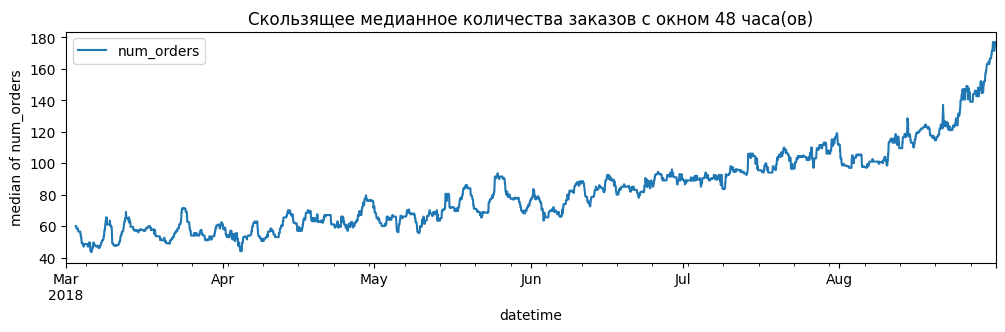

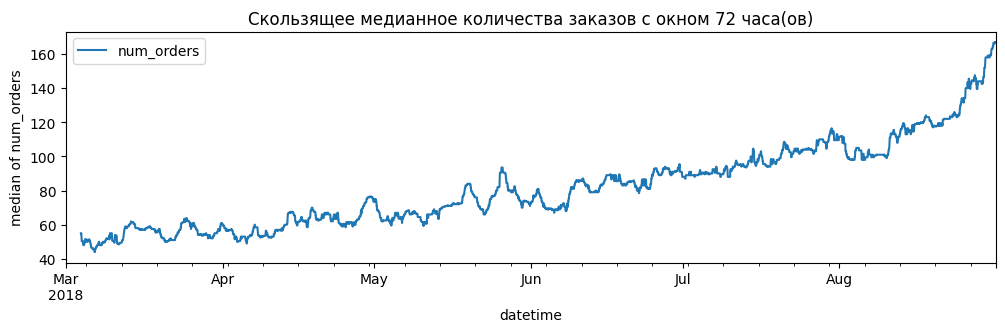

In [10]:
for w in [4, 8, 12, 24, 36, 48, 72]:
    gr = data.rolling(w).median().plot(ylabel='median of num_orders', figsize=(12, 3), title=f'Скользящее медианное количества заказов с окном {w} часа(ов)')
    plt.show()

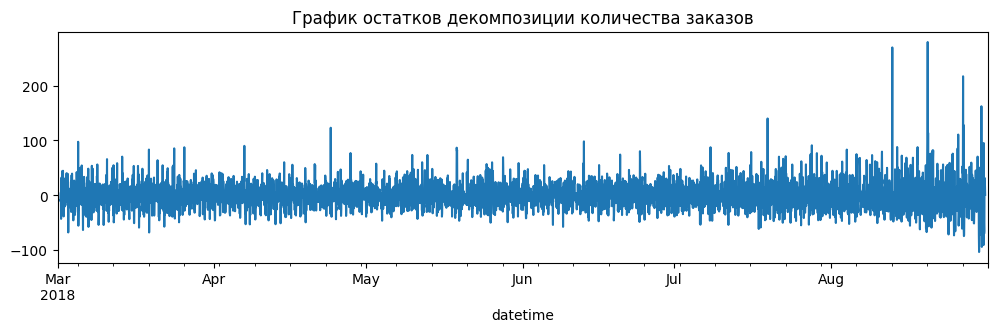

In [11]:
decomposed = seasonal_decompose(data) 

gr = decomposed.resid.plot(title="График остатков декомпозиции количества заказов", figsize=(12, 3))
plt.show()


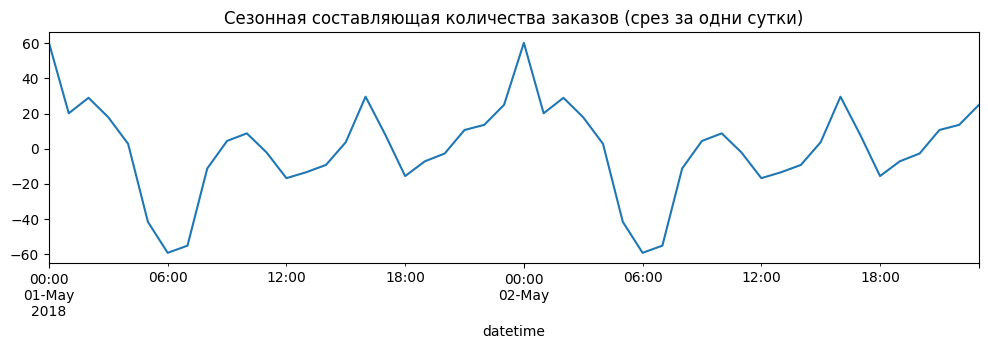

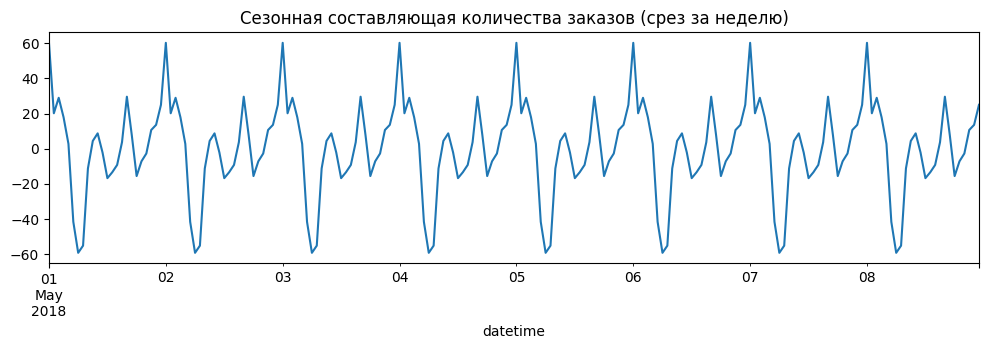

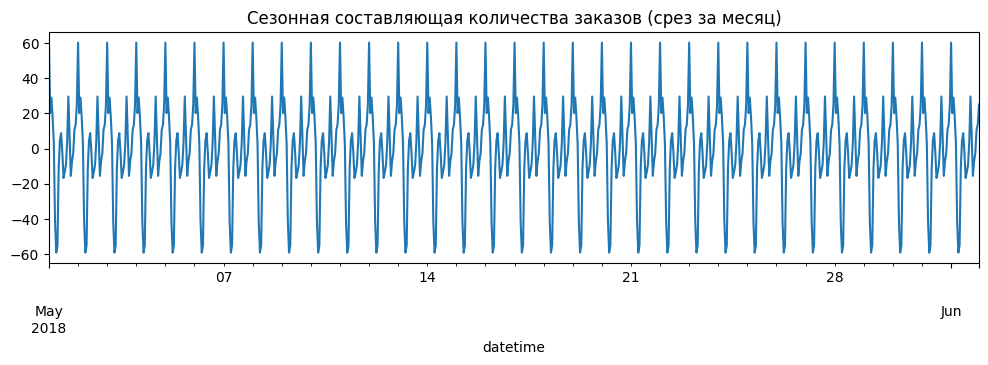

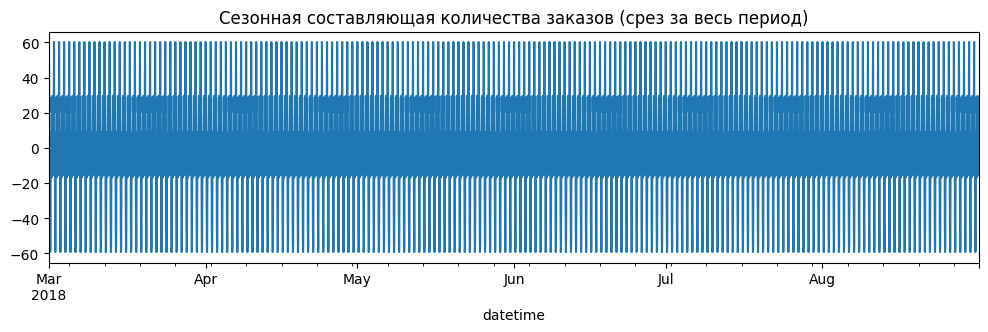

In [12]:
gr = decomposed.seasonal['2018-05-01':'2018-05-02'].plot(title='Сезонная составляющая количества заказов (срез за одни сутки)', figsize=(12, 3))
plt.show()
gr = decomposed.seasonal['2018-05-01':'2018-05-08'].plot(title='Сезонная составляющая количества заказов (срез за неделю)', figsize=(12, 3))
plt.show()
gr = decomposed.seasonal['2018-05-01':'2018-06-01'].plot(title='Сезонная составляющая количества заказов (срез за месяц)', figsize=(12, 3))
plt.show()
gr = decomposed.seasonal.plot(title='Сезонная составляющая количества заказов (срез за весь период)', figsize=(12, 3))
plt.show()

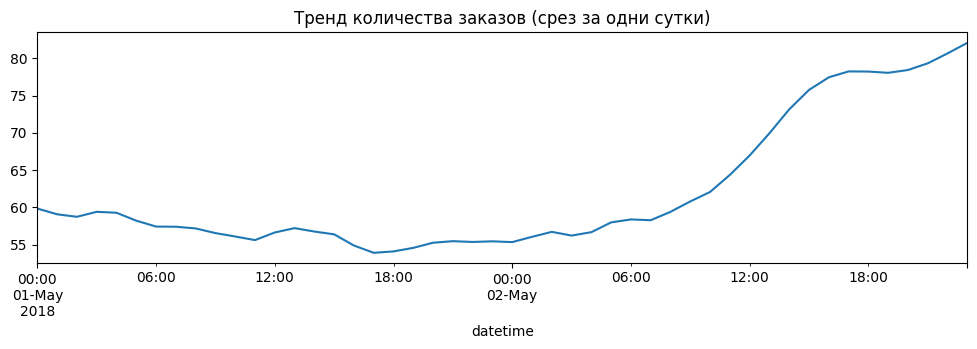

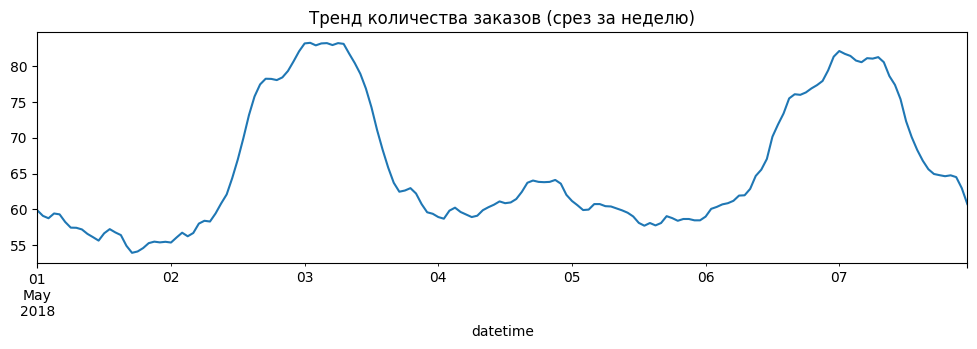

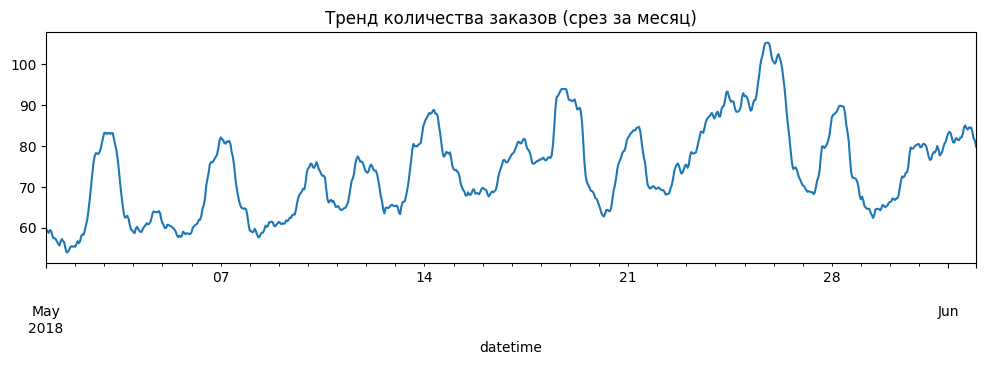

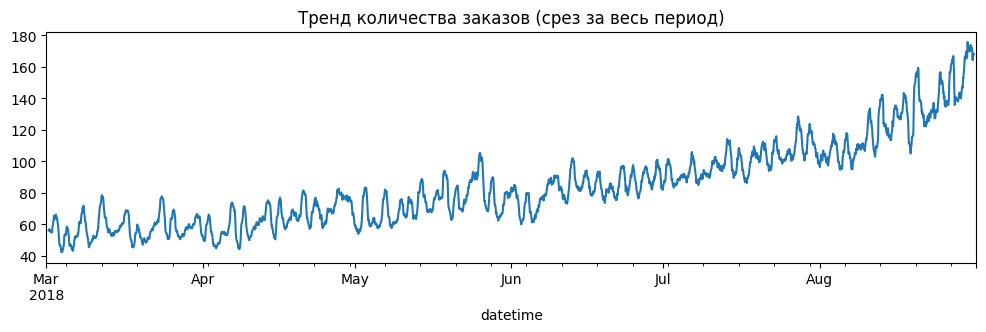

In [13]:
gr = decomposed.trend['2018-05-01':'2018-05-02'].plot(title='Тренд количества заказов (срез за одни сутки)', figsize=(12, 3))
plt.show()
gr = decomposed.trend['2018-05-01':'2018-05-07'].plot(title='Тренд количества заказов (срез за неделю)', figsize=(12, 3))
plt.show()
gr = decomposed.trend['2018-05-01':'2018-06-01'].plot(title='Тренд количества заказов (срез за месяц)', figsize=(12, 3))
plt.show()
gr = decomposed.trend.plot(title='Тренд количества заказов (срез за весь период)', figsize=(12, 3))
plt.show()

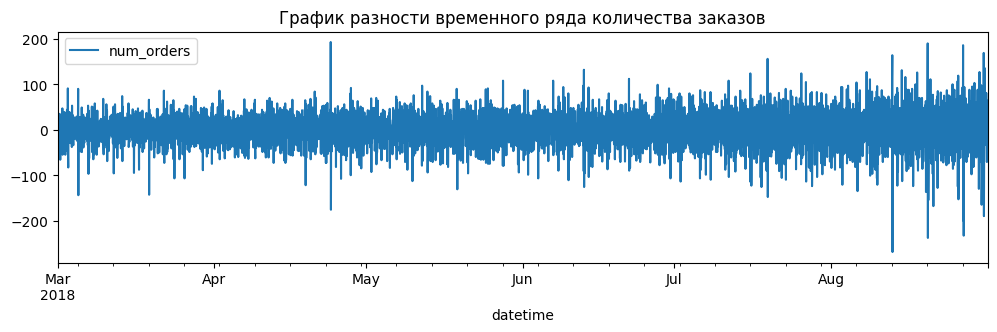

In [14]:
data_sub = data - data.shift(fill_value=0)

gr = data_sub.plot(figsize=(12, 3), title='График разности временного ряда количества заказов')
plt.show()

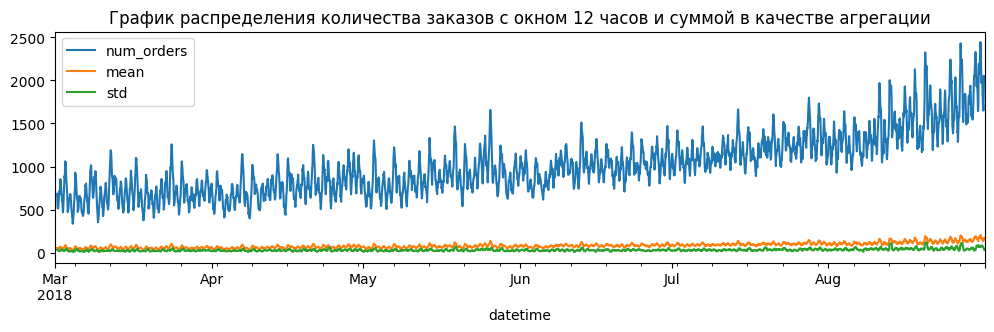

In [15]:
_ = data.rolling(12).sum()
_['mean'] = data.rolling(12).mean()
_['std'] = data.rolling(12).std()
gr = _.plot(figsize=(12, 3), title='График распределения количества заказов с окном 12 часов и суммой в качестве агрегации')

**Промежуточный вывод:**

 - Графики скользящего медианного количества заказов показывают тендецию монотонного увеличения от начала весны к концу лета.
 - Анализ сезонности за сутки показывает высокий уровень заказа в утренние и вечерние часы пик, а также полночь. Также имеется минимумы в районе 6-ти часов.
 - Анализ трендов показывает повышение количества заказов ближе к вечеру. Тренд за весь период имеет восходящий вектор. Трендов за месяц и неделю не наблюдается.
 - График скользящей суммы с окном в 12 часов показывает достаточно стабильное постоянное распределение,что говорит о стационарной природе временного ряда.

# Создание признаков

In [16]:
# hour
data['hour'] = data.index.hour

In [17]:
# day of week
data['day_of_week'] = data.index.dayofweek

In [18]:
# lag shift
for i in range(1, 7):
    data[f'lag_{i}'] = data.num_orders.shift(i)

In [19]:
data['rolling_mean'] = data.num_orders.rolling(6).mean().shift()

In [20]:
data = data.dropna()

In [21]:
data.head()

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,
2018-03-01 06:00:00,12,6,3,6.00,43.00,66.00,71.00,85.00,124.00,65.83
2018-03-01 07:00:00,15,7,3,12.00,6.00,43.00,66.00,71.00,85.00,47.17
2018-03-01 08:00:00,34,8,3,15.00,12.00,6.00,43.00,66.00,71.00,35.50
2018-03-01 09:00:00,69,9,3,34.00,15.00,12.00,6.00,43.00,66.00,29.33
2018-03-01 10:00:00,64,10,3,69.00,34.00,15.00,12.00,6.00,43.00,29.83


In [22]:
data.shape

(4410, 10)

# ML

In [23]:
cols = ['hour', 'day_of_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'rolling_mean']
target = 'num_orders'

In [24]:
x = data[cols]
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.1, random_state=seed)

In [25]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), cols)
    ],
    remainder='passthrough'
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ]
)

In [77]:
param_grid = [
    {
        'model': [LinearRegression()],
        'model__copy_X': [True,False], 
        'model__fit_intercept': [True,False], 
#         'model__positive': [True,False],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors' : [4, 16],
        'model__weights' : ['uniform','distance'],
#         'model__metric' : ['minkowski','euclidean','manhattan'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [SVR()],
        'model__C': [0.1, 1, 10, 100, 1000],  
        'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
        'model__kernel': ['rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [DecisionTreeRegressor(random_state=seed)],
        'model__max_depth': [4, 16],
        'model__min_samples_split': [32, 64],
        'model__min_samples_leaf': [4, 16],
        'model__criterion': ['entropy', 'gini'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
    {
        'model': [CatBoostRegressor(eval_metric='RMSE', random_state=seed)],
#         'model__iterations': [4, 16, 64],
#         'model__learning_rate': [0.05, 0.01],
#         'model__depth': [4, 16, 64],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    },
     {
         'model': [LGBMRegressor(random_state=seed)],
#  #         'model__max_depth': [2, 4, 16, 64, 256],
#          'model__max_depth': range(10, 20),
#  #         'model__num_leaves': [4, 8, 16, 32, 64],
#          'model__num_leaves': range(32, 41),
#          'model__learning_rate': [0.05],
#  #         'model__n_estimators': [4, 16, 64, 256, 512],
#          'model__n_estimators': range(60, 101, 3),
         'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
     },
]

In [113]:
ts_cv = TimeSeriesSplit(n_splits=3)

gs = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid,
    n_jobs=-1,
    cv=ts_cv,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    )

In [119]:
%%time
gs.fit(x_train, y_train)

Fitting 3 folds for each of 204 candidates, totalling 612 fits
Learning rate set to 0.050906
0:	learn: 37.8257758	total: 2.71ms	remaining: 2.71s
1:	learn: 37.0382764	total: 4.67ms	remaining: 2.33s
2:	learn: 36.3202465	total: 6.71ms	remaining: 2.23s
3:	learn: 35.6312205	total: 9.1ms	remaining: 2.27s
4:	learn: 34.9093136	total: 11.2ms	remaining: 2.23s
5:	learn: 34.3084033	total: 13.2ms	remaining: 2.18s
6:	learn: 33.6446128	total: 15.3ms	remaining: 2.17s
7:	learn: 33.1098786	total: 17.4ms	remaining: 2.16s
8:	learn: 32.6175490	total: 19.6ms	remaining: 2.16s
9:	learn: 32.1272615	total: 22.1ms	remaining: 2.19s
10:	learn: 31.6891295	total: 24.5ms	remaining: 2.21s
11:	learn: 31.2270191	total: 26.7ms	remaining: 2.19s
12:	learn: 30.8360514	total: 28.9ms	remaining: 2.19s
13:	learn: 30.5262579	total: 31.1ms	remaining: 2.19s
14:	learn: 30.1412589	total: 33.1ms	remaining: 2.17s
15:	learn: 29.8067666	total: 35.1ms	remaining: 2.16s
16:	learn: 29.4498102	total: 37.3ms	remaining: 2.15s
17:	learn: 29.193

214:	learn: 21.5749005	total: 558ms	remaining: 2.04s
215:	learn: 21.5546190	total: 560ms	remaining: 2.03s
216:	learn: 21.5407560	total: 562ms	remaining: 2.03s
217:	learn: 21.5202927	total: 565ms	remaining: 2.02s
218:	learn: 21.4974827	total: 567ms	remaining: 2.02s
219:	learn: 21.4604401	total: 569ms	remaining: 2.02s
220:	learn: 21.4388486	total: 572ms	remaining: 2.02s
221:	learn: 21.4368160	total: 574ms	remaining: 2.01s
222:	learn: 21.4345592	total: 576ms	remaining: 2.01s
223:	learn: 21.4167950	total: 578ms	remaining: 2s
224:	learn: 21.3859512	total: 581ms	remaining: 2s
225:	learn: 21.3525432	total: 583ms	remaining: 2s
226:	learn: 21.3459438	total: 586ms	remaining: 1.99s
227:	learn: 21.3277978	total: 588ms	remaining: 1.99s
228:	learn: 21.3046437	total: 590ms	remaining: 1.99s
229:	learn: 21.2766653	total: 593ms	remaining: 1.98s
230:	learn: 21.2611682	total: 595ms	remaining: 1.98s
231:	learn: 21.2547077	total: 597ms	remaining: 1.98s
232:	learn: 21.2321864	total: 600ms	remaining: 1.97s
23

444:	learn: 18.7021254	total: 1.13s	remaining: 1.41s
445:	learn: 18.7015278	total: 1.13s	remaining: 1.41s
446:	learn: 18.6907419	total: 1.14s	remaining: 1.41s
447:	learn: 18.6808828	total: 1.14s	remaining: 1.4s
448:	learn: 18.6636997	total: 1.14s	remaining: 1.4s
449:	learn: 18.6586527	total: 1.14s	remaining: 1.4s
450:	learn: 18.6477962	total: 1.15s	remaining: 1.4s
451:	learn: 18.6420727	total: 1.15s	remaining: 1.39s
452:	learn: 18.6331109	total: 1.15s	remaining: 1.39s
453:	learn: 18.6184382	total: 1.15s	remaining: 1.39s
454:	learn: 18.6120953	total: 1.16s	remaining: 1.38s
455:	learn: 18.6001477	total: 1.16s	remaining: 1.38s
456:	learn: 18.5843453	total: 1.16s	remaining: 1.38s
457:	learn: 18.5744111	total: 1.16s	remaining: 1.38s
458:	learn: 18.5738919	total: 1.17s	remaining: 1.37s
459:	learn: 18.5637721	total: 1.17s	remaining: 1.38s
460:	learn: 18.5518265	total: 1.18s	remaining: 1.38s
461:	learn: 18.5347548	total: 1.18s	remaining: 1.38s
462:	learn: 18.5240675	total: 1.19s	remaining: 1.3

660:	learn: 17.0496889	total: 1.68s	remaining: 859ms
661:	learn: 17.0413854	total: 1.68s	remaining: 857ms
662:	learn: 17.0318949	total: 1.68s	remaining: 854ms
663:	learn: 17.0255680	total: 1.68s	remaining: 851ms
664:	learn: 17.0189883	total: 1.69s	remaining: 849ms
665:	learn: 17.0109744	total: 1.69s	remaining: 847ms
666:	learn: 17.0015508	total: 1.69s	remaining: 844ms
667:	learn: 16.9949396	total: 1.69s	remaining: 841ms
668:	learn: 16.9889659	total: 1.69s	remaining: 838ms
669:	learn: 16.9876642	total: 1.7s	remaining: 836ms
670:	learn: 16.9786983	total: 1.7s	remaining: 833ms
671:	learn: 16.9715726	total: 1.7s	remaining: 830ms
672:	learn: 16.9616641	total: 1.7s	remaining: 828ms
673:	learn: 16.9614780	total: 1.71s	remaining: 825ms
674:	learn: 16.9578261	total: 1.71s	remaining: 822ms
675:	learn: 16.9511043	total: 1.71s	remaining: 819ms
676:	learn: 16.9429638	total: 1.71s	remaining: 817ms
677:	learn: 16.9329158	total: 1.71s	remaining: 814ms
678:	learn: 16.9263743	total: 1.72s	remaining: 811

888:	learn: 15.5932519	total: 2.25s	remaining: 281ms
889:	learn: 15.5827973	total: 2.25s	remaining: 279ms
890:	learn: 15.5760478	total: 2.26s	remaining: 276ms
891:	learn: 15.5663305	total: 2.26s	remaining: 274ms
892:	learn: 15.5629449	total: 2.26s	remaining: 271ms
893:	learn: 15.5563624	total: 2.26s	remaining: 268ms
894:	learn: 15.5482292	total: 2.27s	remaining: 266ms
895:	learn: 15.5398034	total: 2.27s	remaining: 263ms
896:	learn: 15.5340455	total: 2.27s	remaining: 261ms
897:	learn: 15.5287333	total: 2.27s	remaining: 258ms
898:	learn: 15.5237040	total: 2.28s	remaining: 256ms
899:	learn: 15.5178297	total: 2.28s	remaining: 253ms
900:	learn: 15.5126436	total: 2.28s	remaining: 251ms
901:	learn: 15.5051559	total: 2.28s	remaining: 248ms
902:	learn: 15.5034948	total: 2.29s	remaining: 245ms
903:	learn: 15.4952349	total: 2.29s	remaining: 243ms
904:	learn: 15.4916249	total: 2.29s	remaining: 240ms
905:	learn: 15.4834860	total: 2.29s	remaining: 238ms
906:	learn: 15.4802510	total: 2.29s	remaining:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['hour',
                                                                          'day_of_week',
                                                                          'lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'rolling_mean'])])),
                                       ('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[...
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'model': [<catboost.core.CatBoostRegressor object at 0x000001E951B69F90>],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']},
                         {'model': [LGBMRegressor(random_state=404)],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(), RobustScaler(),
                                                'passthrough']}],
             scoring='neg_root_mean_squared_error', verbose=1)

In [138]:
gs.best_params_

{'model': <catboost.core.CatBoostRegressor at 0x1e951b69f90>,
 'preprocessor__num': MinMaxScaler()}

In [120]:
gs.best_score_

-28.63061428443565

In [121]:
pred = gs.best_estimator_.predict(x_test)

In [122]:
root_mean_squared_error(y_test, pred)
# 46.9091249951088
# 46.90120439836961

46.90120439836961

In [129]:
feature_importance = pd.DataFrame()
feature_importance.index = x_train.columns
feature_importance['importance'] = gs.best_estimator_.named_steps.model.feature_importances_

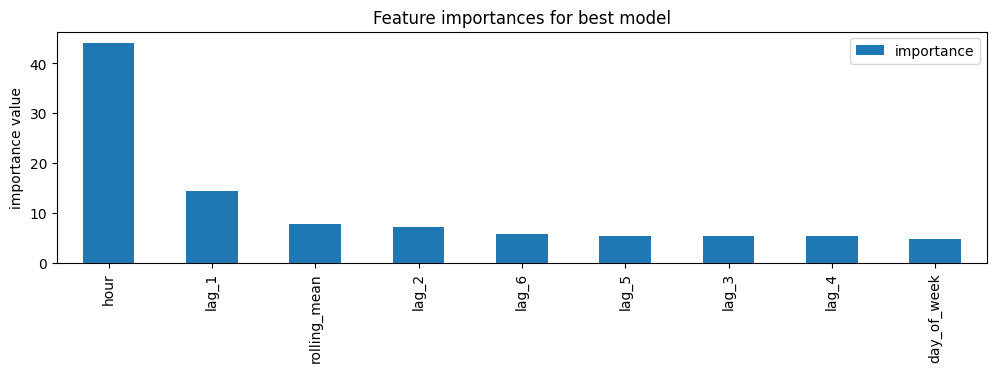

In [137]:
gr = feature_importance.sort_values('importance', ascending=False).plot(kind='bar', figsize=(12, 3), ylabel='importance value', title='Feature importances for best model')

**промежуточный вывод:**

Было обучено несколько различных моделей с гиперпараметрами. На тестовой выборке целевая метрика rmse меньше 48, что является показателем успешности. На графике важности признаков для модели видно, что самые важные для модели признаки - это текущий час, количество заказов за предыдущий час и скользящее среднее количества заказов.

# Итоги

В данном проекте проанализирован временной ряд количества заказов такси (по часам) и спрогнозированно количество заказов на следующий период (час). Имеющаяся выборка достаточно стационарна. Модель успешно достигла целевой метрики на тестовых данных. Из всех созданных признаков наиболее важными для модели оказались: текущий час, предыдущее количество заказов, среднее количестов заказов за предыдущие часы. День недели наименее важен в сравнении с другими признаками.